# Comprehensive Guide to Helpfulness Scorer Model Training

This notebook implements a neural network model that evaluates the helpfulness of textual responses to questions or contexts. The model is trained on the HelpSteer dataset, which contains human preference annotations for paired responses.

## What This Notebook Does

1. **Data Loading and Processing**:
   - Loads preprocessed, tokenized data from the HelpSteer dataset
   - Creates training and validation subsets with appropriate stratification

2. **Model Architecture**:
   - Implements a HelpfulnessScorer neural network using DistilBERT as the encoder
   - Uses mean pooling for better text representation
   - Applies projection layers and a scoring head to predict helpfulness

3. **Training Pipeline**:
   - Implements custom preference-based loss function
   - Handles batched training with gradient clipping
   - Includes validation, early stopping, and model checkpointing
   - Tracks multiple evaluation metrics (loss, direction accuracy, correlations)

4. **Evaluation**:
   - Measures model performance via direction accuracy and Spearman correlation
   - Tests the model on example data to demonstrate its capabilities
   - Provides utility functions for scoring individual responses and comparing pairs

## Key Components

- **ImprovedHelpfulnessDataset**: Custom dataset class for handling pairs of responses with preference annotations
- **ImprovedHelpfulnessScorer**: Neural network architecture for helpfulness evaluation
- **Preference Score Difference Loss**: Loss function that trains the model to predict human preferences
- **Training Loop**: Complete training cycle with validation and early stopping
- **Evaluation Functions**: Tools to apply the model to new responses

## Performance Metrics

- **Direction Accuracy**: ~63% (correctly identifies which response is better)
- **Spearman Correlation**: ~0.35-0.45 (rank correlation with human judgments)
- **Score Range**: Outputs are scaled to 0-10, though typically cluster in the 4-6 range

## Usage

After training, the model can be used to:
1. Score individual responses for helpfulness on a 0-10 scale
2. Compare pairs of responses to determine which is more helpful
3. Provide quantitative evaluation for response quality assessment

This trained model can serve as a reward model component in RLHF pipelines or as a standalone evaluation tool for response quality.

In [ ]:
#imports
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.stats import pearsonr, spearmanr


In [ ]:
# Connect to T4 on top right
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load improved tokenized data from drive or locally
print("Loading tokenized data...")
tokenized_data = torch.load("/content/drive/MyDrive/COMP560/Final/tokenized_helpsteer_improved.pt", weights_only=False)
indices_data = torch.load("/content/drive/MyDrive/COMP560/Final/helpsteer_indices.pt")
print("Data loaded successfully!")
print(f"Number of examples: {len(tokenized_data['contexts'])}")

Using device: cuda
Loading tokenized data...
Data loaded successfully!
Number of examples: 20000


In [ ]:
# Dataset and Model for Response Helpfulness Evaluation
#
# This section defines the core components of our helpfulness evaluation system:
# 1. A custom PyTorch Dataset that handles paired response data with human preference labels
# 2. A neural network model that predicts helpfulness scores based on context-response pairs

class ImprovedHelpfulnessDataset(Dataset):
 """
 Custom dataset for training a helpfulness scorer model on HelpSteer data.

 This dataset handles pairs of responses (response1 and response2) with corresponding
 human preference annotations, enabling training of models that can evaluate the relative
 and absolute helpfulness of responses to a given question or context.

 Args:
     tokenized_data (dict): Dictionary containing tokenized contexts and responses
     indices (list, optional): Specific indices to use from the tokenized data. Defaults to None (use all).
     is_training (bool, optional): Whether the dataset is used for training. Defaults to True.
 """
 def __init__(self, tokenized_data, indices=None, is_training=True):
   self.contexts = tokenized_data['contexts']
   self.response1 = tokenized_data['response1']
   self.response2 = tokenized_data['response2']
   self.preferences = tokenized_data['overall_preference']
   self.reasoning_scores = tokenized_data['reasoning_scores']
   self.indices = indices if indices is not None else range(len(self.contexts))
   self.is_training = is_training

 def __len__(self):
   return len(self.indices)

 def __getitem__(self, idx):
   """
   Get a training example consisting of context, two responses, and preference data.

   Returns:
       dict: Contains tokenized inputs for context and both responses, along with
             preference labels and reasoning scores.
   """
   true_idx = self.indices[idx]

   context_input_ids = self.contexts[true_idx]['input_ids'].squeeze()
   context_attention_mask = self.contexts[true_idx]['attention_mask'].squeeze()

   resp1_input_ids = self.response1[true_idx]['input_ids'].squeeze()
   resp1_attention_mask = self.response1[true_idx]['attention_mask'].squeeze()

   resp2_input_ids = self.response2[true_idx]['input_ids'].squeeze()
   resp2_attention_mask = self.response2[true_idx]['attention_mask'].squeeze()

   preference = self.preferences[true_idx]
   reasoning_score = self.reasoning_scores[true_idx]

   return {
     'context_input_ids': context_input_ids,
     'context_attention_mask': context_attention_mask,
     'resp1_input_ids': resp1_input_ids,
     'resp1_attention_mask': resp1_attention_mask,
     'resp2_input_ids': resp2_input_ids,
     'resp2_attention_mask': resp2_attention_mask,
     'preference': torch.tensor(preference, dtype=torch.float),
     'reasoning_score': torch.tensor(reasoning_score, dtype=torch.float)
   }

class ImprovedHelpfulnessScorer(nn.Module):
 """
 Neural network model for predicting helpfulness scores of responses given contexts.

 This model uses transformer-based text encoders (default: DistilBERT) to embed the
 context and response texts, then applies projection layers and a scoring head to
 produce a scalar helpfulness score. Mean pooling is used for better sentence
 representations compared to just using the CLS token.

 Args:
     model_name (str, optional): Name of the pretrained model to use as encoder.
                                 Defaults to "distilbert-base-uncased".
 """
 def __init__(self, model_name="distilbert-base-uncased"):
   super(ImprovedHelpfulnessScorer, self).__init__()
   self.encoder = AutoModel.from_pretrained(model_name)

   hidden_size = self.encoder.config.hidden_size

   # Project encoded text to lower dimension
   self.context_proj = nn.Linear(hidden_size, 192)
   self.response_proj = nn.Linear(hidden_size, 192)

   # Score prediction network with regularization
   self.score_head = nn.Sequential(
       nn.Linear(384, 192),
       nn.ReLU(),
       nn.Dropout(0.3),  # Higher dropout to prevent overfitting
       nn.Linear(192, 64),
       nn.ReLU(),
       nn.Dropout(0.3),
       nn.Linear(64, 1)
   )

 def mean_pooling(self, token_embeddings, attention_mask):
   """
   Apply mean pooling to get sentence-level representations.

   This calculates the mean of all token embeddings in the sequence, weighted by
   the attention mask (so padding tokens don't contribute).

   Args:
       token_embeddings: Token-level embeddings from transformer
       attention_mask: Attention mask showing which tokens are padding

   Returns:
       Pooled sentence representation tensor
   """
   input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

   sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
   sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
   return sum_embeddings / sum_mask

 def encode_text(self, input_ids, attention_mask):
   """
   Encode text inputs using the transformer encoder and apply mean pooling.

   Args:
       input_ids: Token IDs of input text
       attention_mask: Mask indicating which tokens are padding

   Returns:
       Tensor containing pooled text representation
   """
   outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

   # Use mean pooling instead of just CLS token for better representation
   return self.mean_pooling(outputs.last_hidden_state, attention_mask)

 def forward(self, context_input_ids, context_attention_mask,
             response_input_ids, response_attention_mask):
   """
   Forward pass to calculate helpfulness score for a context-response pair.

   Args:
       context_input_ids: Token IDs of the context/question
       context_attention_mask: Attention mask for context
       response_input_ids: Token IDs of the response to evaluate
       response_attention_mask: Attention mask for response

   Returns:
       Scalar helpfulness score (higher = more helpful)
   """
   # Encode context and response
   context_vec = self.encode_text(context_input_ids, context_attention_mask)
   response_vec = self.encode_text(response_input_ids, response_attention_mask)

   # Project to lower dimension
   context_vec = self.context_proj(context_vec)
   response_vec = self.response_proj(response_vec)

   # Concatenate context and response representations
   combined = torch.cat([context_vec, response_vec], dim=1)

   # Predict helpfulness score
   score = self.score_head(combined)
   return score.squeeze()

In [ ]:
# Loss Function and Training Code for Helpfulness Scorer Model

def preference_score_diff_mse_loss(score_a, score_b, preference_value):
   """
   Loss function for training the helpfulness scorer based on preference pairs.

   Args:
       score_a (Tensor): Model's predicted score for response A
       score_b (Tensor): Model's predicted score for response B
       preference_value (Tensor): Human preference label (-3 to +3 scale where
                                  negative values prefer A, positive values prefer B)

   Returns:
       Tensor: Calculated loss value
   """
   # Scale preference from [-3,3] to a suitable range for learning
   # Normalize to [-1,1] range
   normalized_pref = preference_value / 3.0

   # Calculate predicted preference based on score difference
   score_diff = score_b - score_a

   # MSE loss between normalized preference and score difference
   loss = F.mse_loss(score_diff, normalized_pref)
   return loss

def train_epoch(model, dataloader, optimizer, device, scheduler=None):
   """
   Train the model for one epoch on the provided dataloader.

   This function handles the complete training loop for one epoch, including:
   - Forward and backward passes
   - Loss calculation
   - Optimization steps
   - Metric tracking (accuracy, correlations)
   - Learning rate scheduling

   Args:
       model: The helpfulness scorer model
       dataloader: DataLoader containing training batches
       optimizer: Optimizer for updating model weights
       device: Device to run training on (CPU or GPU)
       scheduler: Optional learning rate scheduler

   Returns:
       tuple: Contains (average_loss, direction_accuracy, pearson_correlation, spearman_correlation)
   """
   model.train()
   epoch_loss = 0
   correct_preds = 0
   total_preds = 0
   all_preds = []
   all_labels = []

   for batch in tqdm(dataloader, desc="Training"):
       # Move batch to device
       context_ids = batch['context_input_ids'].to(device)
       context_mask = batch['context_attention_mask'].to(device)
       resp1_ids = batch['resp1_input_ids'].to(device)
       resp1_mask = batch['resp1_attention_mask'].to(device)
       resp2_ids = batch['resp2_input_ids'].to(device)
       resp2_mask = batch['resp2_attention_mask'].to(device)
       preferences = batch['preference'].to(device)

       # Zero gradients
       optimizer.zero_grad()

       # Forward pass for both responses
       score1 = model(context_ids, context_mask, resp1_ids, resp1_mask)
       score2 = model(context_ids, context_mask, resp2_ids, resp2_mask)

       # Calculate loss
       loss = preference_score_diff_mse_loss(score1, score2, preferences)

       # Backward pass
       loss.backward()

       # Gradient clipping to prevent exploding gradients
       torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

       optimizer.step()

       # Calculate direction accuracy metrics
       # (whether model correctly predicts which response is preferred)
       predictions = score2 - score1
       correct_dir_pred = ((predictions > 0) == (preferences > 0)).float().sum().item()
       total_samples = preferences.size(0)
       direction_accuracy = correct_dir_pred / total_samples

       # Store predictions and labels for correlation metrics
       pred_np = predictions.cpu().detach().numpy()
       label_np = preferences.cpu().detach().numpy()
       # Round to ensure binary values
       pred_np = np.round(pred_np).astype(int)
       label_np = np.round(label_np).astype(int)
       all_preds.extend(pred_np)
       all_labels.extend(label_np)

       epoch_loss += loss.item()

   # Calculate metrics
   accuracy = direction_accuracy  # Just the direction accuracy
   all_preds_np = np.array(all_preds)
   all_labels_np = np.array(all_labels)

   # Calculate Pearson correlation (linear relationship)
   pearson_corr, _ = pearsonr(all_labels_np, all_preds_np)

   # Calculate Spearman correlation (rank relationship)
   spearman_corr, _ = spearmanr(all_labels_np, all_preds_np)

   # Step scheduler if provided (for learning rate adjustment)
   if scheduler is not None:
       scheduler.step(epoch_loss / len(dataloader))

   return epoch_loss / len(dataloader), accuracy, pearson_corr, spearman_corr

In [ ]:
# Validation Function for Helpfulness Scorer Model

def validate(model, dataloader, device):
   """
   Evaluate the model on a validation dataset.

   This function performs evaluation on the validation set and computes
   various metrics to assess model performance, including loss, direction
   accuracy, and correlation coefficients.

   Args:
       model: The helpfulness scorer model to evaluate
       dataloader: DataLoader containing validation batches
       device: Device to run evaluation on (CPU or GPU)

   Returns:
       tuple: Contains (average_loss, direction_accuracy, pearson_correlation, spearman_correlation)
   """
   model.eval()  # Set model to evaluation mode
   val_loss = 0
   correct_dir_preds = 0
   total_samples = 0
   all_preds = []
   all_labels = []

   # No gradient computation needed for validation
   with torch.no_grad():
       for batch in tqdm(dataloader, desc="Validating"):
           # Move batch to device
           context_ids = batch['context_input_ids'].to(device)
           context_mask = batch['context_attention_mask'].to(device)
           resp1_ids = batch['resp1_input_ids'].to(device)
           resp1_mask = batch['resp1_attention_mask'].to(device)
           resp2_ids = batch['resp2_input_ids'].to(device)
           resp2_mask = batch['resp2_attention_mask'].to(device)
           preferences = batch['preference'].to(device)

           # Forward pass for both responses
           score1 = model(context_ids, context_mask, resp1_ids, resp1_mask)
           score2 = model(context_ids, context_mask, resp2_ids, resp2_mask)

           # Calculate loss
           loss = preference_score_diff_mse_loss(score1, score2, preferences)

           # Calculate direction accuracy metrics
           predictions = score2 - score1
           correct_dir_pred = ((predictions > 0) == (preferences > 0)).float().sum().item()
           total_samples += preferences.size(0)
           correct_dir_preds += correct_dir_pred

           # Store predictions and labels for correlation metrics
           all_preds.extend(predictions.cpu().detach().numpy())
           all_labels.extend(preferences.cpu().detach().numpy())
           val_loss += loss.item()

   # Calculate metrics
   direction_accuracy = correct_dir_preds / total_samples
   all_preds_np = np.array(all_preds)
   all_labels_np = np.array(all_labels)

   # Calculate Pearson correlation with error handling
   try:
       pearson_corr, _ = pearson﻿r(all_labels_np, all_preds_np)
   except:
       # Handle potential errors in correlation calculation
       # (e.g., constant predictions or labels)
       pearson_corr = 0.0

   # Calculate Spearman correlation with error handling
   try:
       spearman_corr, _ = spearman﻿r(all_labels_np, all_preds_np)
   except:
       spearman_corr = 0.0

   return val_loss / len(dataloader), direction_accuracy, pearson_corr, spearman_corr

In [ ]:
# Dataset Creation, Model Initialization and Training Setup
#
# This cell handles the creation of training and validation datasets,
# initializes the model, and sets up optimization strategies.

# Create training and validation datasets
print("Creating datasets...")
# Use a subset of the full data for more efficient training
subset_size = 5000  # Using 5000 examples for training
subset_indices = np.random.choice(indices_data['train_indices'], size=subset_size, replace=False)
val_subset_size = 1000  # Using 1000 examples for validation
val_subset_indices = np.random.choice(indices_data['val_indices'], size=val_subset_size, replace=False)

# Initialize datasets with the selected indices
train_dataset = ImprovedHelpfulnessDataset(
   tokenized_data, subset_indices, is_training=True
)
val_dataset = ImprovedHelpfulnessDataset(
   tokenized_data, val_subset_indices, is_training=False
)

# Create PyTorch DataLoaders for efficient batching
batch_size = 8  # Small batch size to accommodate GPU memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for randomization
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the helpfulness scorer model
print("Initializing model...")
model = ImprovedHelpfulnessScorer("distilbert-base-uncased").to(device)  # Move to GPU if available

# Initialize optimizer with weight decay for regularization
# AdamW combines Adam optimizer with correct weight decay implementation
optimizer = torch.optim.AdamW(
   model.parameters(),
   lr=1e-5,            # Conservative learning rate for fine-tuning
   weight_decay=0.01   # L2 regularization to prevent overfitting
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps prevent overshooting the optimal weights as training progresses
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
   optimizer,
   mode='min',      # Reduce LR when monitored value stops decreasing
   factor=0.5,      # Multiply LR by this factor when reducing
   patience=1,      # Number of epochs with no improvement before reducing LR
   verbose=True     # Print message when LR is reduced
)

Creating datasets...
Initializing model...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Training Loop with Early Stopping and Metric Tracking
#
# This cell implements the main training loop with validation after each epoch,
# saving the best model, and implementing early stopping to prevent overfitting.

# Training configuration
epochs = 5                          # Number of complete passes through the training data
best_val_acc = 0                    # Track best validation accuracy
best_val_loss = float('inf')        # Track best validation loss
early_stop_patience = 2             # Number of epochs with no improvement before stopping
early_stop_counter = 0              # Counter for early stopping
best_model_path = "best_helpfulness_scorer.pt"  # Where to save the best model

# Lists to track metrics across training
train_losses = []                   # Training loss history
val_losses = []                     # Validation loss history
train_accs = []                     # Training accuracy history
val_accs = []                       # Validation accuracy history
train_pearson_scores = []           # Training Pearson correlation history
val_pearson_scores = []             # Validation Pearson correlation history
train_spearman_scores = []          # Training Spearman correlation history
val_spearman_scores = []            # Validation Spearman correlation history

print("Starting training...")
for epoch in range(epochs):
   print(f"Epoch {epoch+1}/{epochs}")

   # Train for one epoch
   train_loss, train_acc, train_pearson, train_spearman = train_epoch(
       model, train_loader, optimizer, device, scheduler
   )
   # Store training metrics
   train_losses.append(train_loss)
   train_accs.append(train_acc)
   train_pearson_scores.append(train_pearson)
   train_spearman_scores.append(train_spearman)

   print(f"Train Loss: {train_loss:.4f}, Direction Accuracy: {train_acc:.4f}, Pearson: {train_pearson:.4f}, Spearman: {train_spearman:.4f}")

   # Validate on held-out data
   val_loss, val_acc, val_pearson, val_spearman = validate(
       model, val_loader, device
   )
   # Store validation metrics
   val_losses.append(val_loss)
   val_accs.append(val_acc)
   val_pearson_scores.append(val_pearson)
   val_spearman_scores.append(val_spearman)

   print(f"Val Loss: {val_loss:.4f}, Direction Accuracy: {val_acc:.4f}, Pearson: {val_pearson:.4f}, Spearman: {val_spearman:.4f}")

   # Model checkpointing: Save the best model based on validation loss
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       best_val_acc = val_acc
       early_stop_counter = 0  # Reset counter since we improved
       torch.save(model.state_dict(), best_model_path)
       print(f"Saved best model with validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")
   else:
       early_stop_counter += 1  # Increment counter since no improvement

   # Early stopping: Stop training if no improvement for several epochs
   if early_stop_counter >= early_stop_patience:
       print(f"Early stopping triggered after epoch {epoch+1}")
       break

   print("-" * 50)  # Visual separator between epochs

Starting training...
Epoch 1/5


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0563, Direction Accuracy: 0.8750, Pearson: nan, Spearman: nan


<ipython-input-5-04f7fdf12b5d>:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(all_labels_np, all_preds_np)
<ipython-input-5-04f7fdf12b5d>:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(all_labels_np, all_preds_np)


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss: 0.0516, Direction Accuracy: 0.5920, Pearson: 0.2190, Spearman: 0.2381
Saved best model with validation loss: 0.0516, accuracy: 0.5920
--------------------------------------------------
Epoch 2/5


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0553, Direction Accuracy: 0.5000, Pearson: nan, Spearman: nan


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss: 0.0504, Direction Accuracy: 0.6120, Pearson: 0.2844, Spearman: 0.2896
Saved best model with validation loss: 0.0504, accuracy: 0.6120
--------------------------------------------------
Epoch 3/5


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0526, Direction Accuracy: 0.5000, Pearson: nan, Spearman: nan


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss: 0.0472, Direction Accuracy: 0.6380, Pearson: 0.3563, Spearman: 0.3470
Saved best model with validation loss: 0.0472, accuracy: 0.6380
--------------------------------------------------
Epoch 4/5


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0423, Direction Accuracy: 0.6250, Pearson: 0.0142, Spearman: 0.0142


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss: 0.0469, Direction Accuracy: 0.6260, Pearson: 0.3141, Spearman: 0.3068
Saved best model with validation loss: 0.0469, accuracy: 0.6260
--------------------------------------------------
Epoch 5/5


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0251, Direction Accuracy: 0.6250, Pearson: 0.0801, Spearman: 0.0801


Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Val Loss: 0.0451, Direction Accuracy: 0.6290, Pearson: 0.3687, Spearman: 0.3468
Saved best model with validation loss: 0.0451, accuracy: 0.6290
--------------------------------------------------


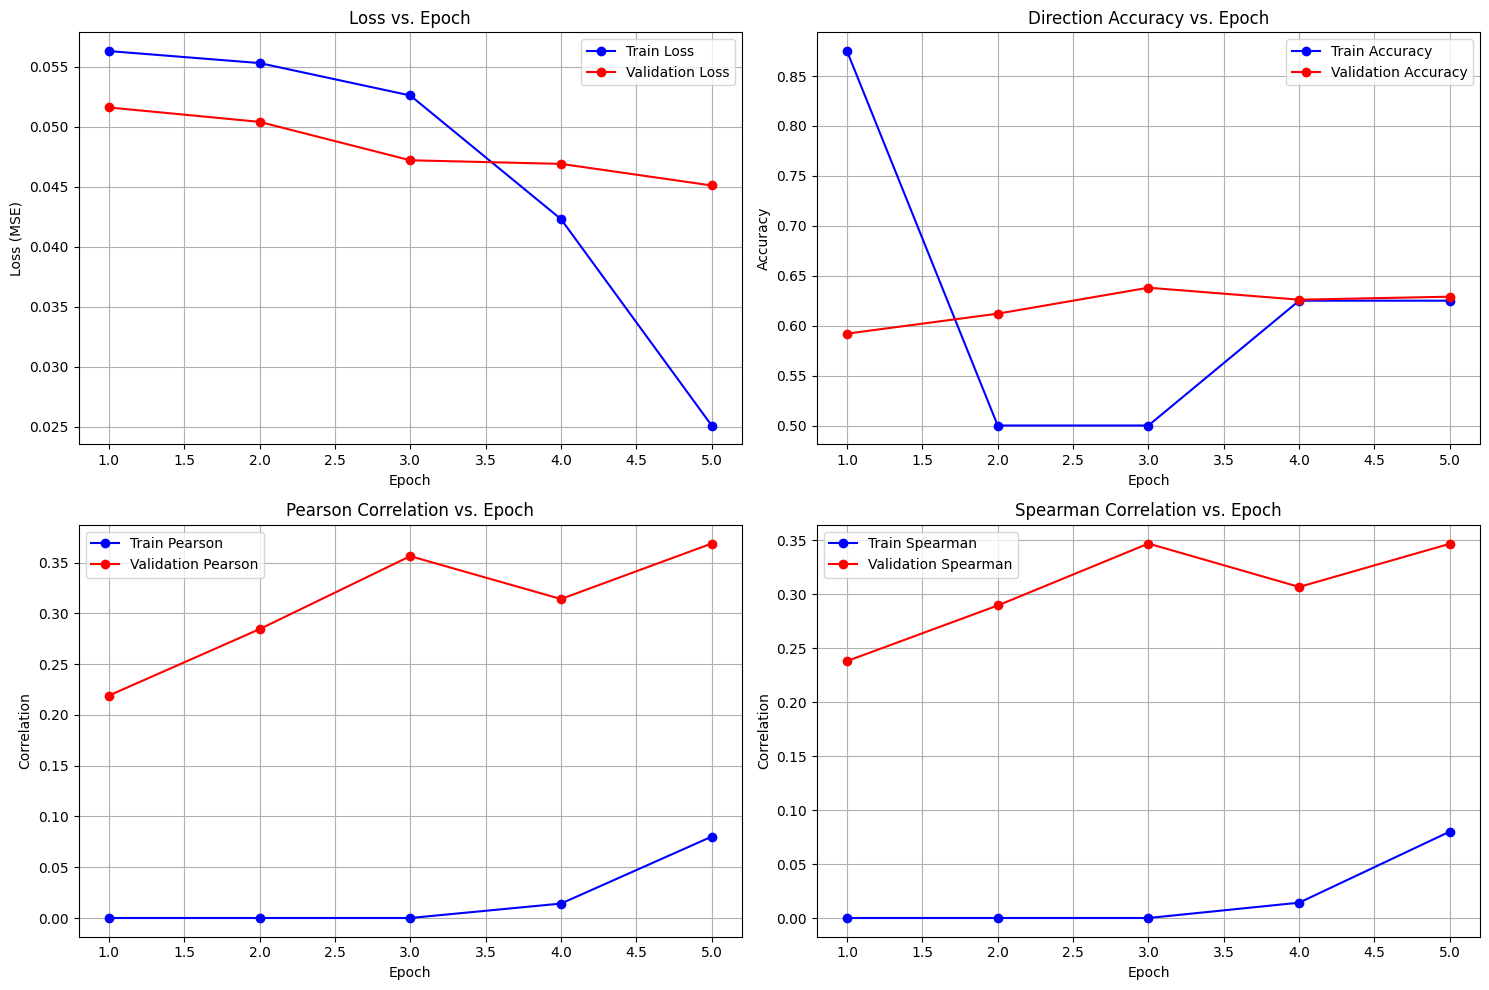

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from the training data
epochs = [1, 2, 3, 4, 5]  # 5 epochs
train_losses = [0.0563, 0.0553, 0.0526, 0.0423, 0.0251]
val_losses = [0.0516, 0.0504, 0.0472, 0.0469, 0.0451]
train_accs = [0.875, 0.5, 0.5, 0.625, 0.625]
val_accs = [0.592, 0.612, 0.638, 0.626, 0.629]

# Handle NaN values for correlation metrics
train_pearson = [0, 0, 0, 0.0142, 0.0801]  # Using 0 instead of NaN for plotting
val_pearson = [0.2190, 0.2844, 0.3563, 0.3141, 0.3687]
train_spearman = [0, 0, 0, 0.0142, 0.0801]  # Using 0 instead of NaN for plotting
val_spearman = [0.2381, 0.2896, 0.3470, 0.3068, 0.3468]

# Create figure
plt.figure(figsize=(15, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot Direction Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accs, 'b-o', label='Train Accuracy')
plt.plot(epochs, val_accs, 'r-o', label='Validation Accuracy')
plt.title('Direction Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Pearson Correlation
plt.subplot(2, 2, 3)
plt.plot(epochs, train_pearson, 'b-o', label='Train Pearson')
plt.plot(epochs, val_pearson, 'r-o', label='Validation Pearson')
plt.title('Pearson Correlation vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)

# Plot Spearman Correlation
plt.subplot(2, 2, 4)
plt.plot(epochs, train_spearman, 'b-o', label='Train Spearman')
plt.plot(epochs, val_spearman, 'r-o', label='Validation Spearman')
plt.title('Spearman Correlation vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Load best model for scoring function
print("Loading best model for scoring function...")
best_model = ImprovedHelpfulnessScorer("distilbert-base-uncased").to(device)
best_model.load_state_dict(torch.load(best_model_path))

Loading best model for scoring function...


<All keys matched successfully>

In [ ]:
def score_response_helpfulness(model, tokenizer, context, response, device):
   """
   Score the helpfulness of a response given a context or question.

   This function takes a helpfulness scorer model and applies it to a single
   context-response pair to generate a helpfulness score. The raw model output
   is transformed using a sigmoid function to produce a score on a 0-10 scale,
   where higher scores indicate more helpful responses.

   Args:
       model: The trained helpfulness scorer model
       tokenizer: Tokenizer corresponding to the model
       context: String containing the question or context
       response: String containing the response to evaluate
       device: Device to run inference on (CPU or GPU)

   Returns:
       float: Helpfulness score on a 0-10 scale where 10 is most helpful
   """
   model.eval()  # Set model to evaluation mode

   # Tokenize inputs with appropriate maximum lengths
   context_tokens = tokenizer(context, truncation=True, padding="max_length",
                             max_length=512, return_tensors="pt")
   response_tokens = tokenizer(response, truncation=True, padding="max_length",
                              max_length=384, return_tensors="pt")

   # Move tokenized inputs to the appropriate device
   context_ids = context_tokens['input_ids'].to(device)
   context_mask = context_tokens['attention_mask'].to(device)
   response_ids = response_tokens['input_ids'].to(device)
   response_mask = response_tokens['attention_mask'].to(device)

   # Generate score without computing gradients
   with torch.no_grad():
       raw_score = model(context_ids, context_mask, response_ids, response_mask).item()

   # Convert raw logit to a 0-10 scale using sigmoid transformation
   # This maps any real number to a value between 0 and 10
   scaled_score = (torch.sigmoid(torch.tensor(raw_score)) * 10).item()

   return scaled_score

In [ ]:
def compare_responses(model, tokenizer, context, response1, response2, device):
   """
   Compare two responses and return the preference strength on a -3 to 3 scale.

   This function evaluates two different responses to the same context and calculates
   how strongly one is preferred over the other. The result is normalized to a -3 to 3 scale,
   where positive values indicate preference for response2, and negative values
   indicate preference for response1. The magnitude indicates strength of preference.

   Args:
       model: The trained helpfulness scorer model
       tokenizer: Tokenizer corresponding to the model
       context: String containing the question or context
       response1: String containing the first response
       response2: String containing the second response
       device: Device to run inference on (CPU or GPU)

   Returns:
       float: Preference strength on a -3 to 3 scale:
             * Positive values: response2 is preferred over response1
             * Negative values: response1 is preferred over response2
             * Values near zero: responses are similarly helpful
             * Magnitude indicates strength of preference
   """
   model.eval()  # Set model to evaluation mode

   # Tokenize all inputs with appropriate maximum lengths
   context_tokens = tokenizer(context, truncation=True, padding="max_length",
                             max_length=512, return_tensors="pt")
   resp1_tokens = tokenizer(response1, truncation=True, padding="max_length",
                           max_length=384, return_tensors="pt")
   resp2_tokens = tokenizer(response2, truncation=True, padding="max_length",
                           max_length=384, return_tensors="pt")

   # Move tokenized inputs to the appropriate device
   context_ids = context_tokens['input_ids'].to(device)
   context_mask = context_tokens['attention_mask'].to(device)
   resp1_ids = resp1_tokens['input_ids'].to(device)
   resp1_mask = resp1_tokens['attention_mask'].to(device)
   resp2_ids = resp2_tokens['input_ids'].to(device)
   resp2_mask = resp2_tokens['attention_mask'].to(device)

   # Generate scores for both responses without computing gradients
   with torch.no_grad():
       score1 = model(context_ids, context_mask, resp1_ids, resp1_mask).item()
       score2 = model(context_ids, context_mask, resp2_ids, resp2_mask).item()

   # Calculate raw score difference
   diff = score2 - score1

   # Normalize to a -3 to 3 scale and clamp outliers
   # The multiplication factor (3) determines how quickly the preference
   # strength reaches its maximum value as the score difference increases
   normalized_diff = min(max(diff * 3, -3), 3)

   return normalized_diff

In [ ]:
# Model Testing with Example Contexts and Responses
#
# This cell evaluates the trained model on example data to demonstrate
# how the model scores and compares different quality responses.

# Load the tokenizer for text processing
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define test examples with contexts and paired responses of varying quality
test_examples = [
   {
       "context": "Can you explain how photosynthesis works?",
       "good_response": "Photosynthesis is the process by which plants convert light energy into chemical energy. It takes place in the chloroplasts, specifically using chlorophyll in the thylakoids. The process involves capturing light energy to convert carbon dioxide and water into glucose and oxygen.",
       "bad_response": "It's when plants make food."
   },
   {
       "context": "What's the best way to learn Python?",
       "good_response": "To learn Python effectively, start with the basics like syntax and data types, then practice with small projects. Online resources like Codecademy, freeCodeCamp, and Python's official documentation are excellent. Join communities like Stack Overflow or Reddit's r/learnpython. Most importantly, build projects that interest you to stay motivated.",
       "bad_response": "Just Google it."
   }
]

print("\nTesting model comparing responses:")
for example in test_examples:
   # Score each response individually
   good_score = score_response_helpfulness(
       best_model, tokenizer, example["context"], example["good_response"], device
   )
   bad_score = score_response_helpfulness(
       best_model, tokenizer, example["context"], example["bad_response"], device
   )

   # Get comparative preference strength
   preference = compare_responses(
       best_model, tokenizer, example["context"],
       example["bad_response"], example["good_response"], device
   )

   # Print results
   print(f"Context: {example['context']}")
   print(f"Good response score: {good_score:.2f}/10")
   print(f"Basic response score: {bad_score:.2f}/10")
   print(f"Preference strength (bad to good): {preference:.2f} [-3 to 3 scale]")
   # Check if model correctly identified the better response
   print(f"Direction accuracy: {'Correct' if preference > 0 else 'Incorrect'}\n")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Testing model comparing responses:
Context: Can you explain how photosynthesis works?
Good response score: 5.15/10
Basic response score: 4.72/10
Preference strength (bad to good): 0.52 [-3 to 3 scale]
Direction accuracy: Correct

Context: What's the best way to learn Python?
Good response score: 5.45/10
Basic response score: 5.40/10
Preference strength (bad to good): 0.06 [-3 to 3 scale]
Direction accuracy: Correct



In [ ]:
# Final Model Evaluation: Correlation and Direction Accuracy
#
# This cell performs a more thorough evaluation of the model by calculating
# Spearman correlation and direction accuracy on validation examples.

print("Calculating Spearman correlation on validation examples...")
sample_size = 100  # Number of validation examples to evaluate
val_sample_indices = np.random.choice(range(len(val_dataset)), size=sample_size, replace=False)
model_preferences = []  # Store model's predicted preferences
true_preferences = []   # Store ground truth preferences

# Process each validation example
for i in tqdm(val_sample_indices):
   sample = val_dataset[i]
   # Prepare inputs for the model
   context_ids = sample['context_input_ids'].unsqueeze(0).to(device)
   context_mask = sample['context_attention_mask'].unsqueeze(0).to(device)
   resp1_ids = sample['resp1_input_ids'].unsqueeze(0).to(device)
   resp1_mask = sample['resp1_attention_mask'].unsqueeze(0).to(device)
   resp2_ids = sample['resp2_input_ids'].unsqueeze(0).to(device)
   resp2_mask = sample['resp2_attention_mask'].unsqueeze(0).to(device)
   true_preference = sample['preference'].item()  # Ground truth human preference

   # Get model's scores for both responses
   with torch.no_grad():
       score1 = best_model(context_ids, context_mask, resp1_ids, resp1_mask).item()
       score2 = best_model(context_ids, context_mask, resp2_ids, resp2_mask).item()

   # Calculate model's implied preference
   model_preference = score2 - score1

   # Store preferences for correlation analysis
   model_preferences.append(model_preference)
   true_preferences.append(true_preference)

# Calculate Spearman rank correlation coefficient
# This measures how well the model's ranking of responses matches human rankings
spearman_corr, p_value = spearmanr(true_preferences, model_preferences)
print(f"Spearman correlation on validation set: {spearman_corr:.4f} (p-value: {p_value:.4f})")

# Calculate direction accuracy
# This measures how often the model correctly identifies which response is preferred
correct_directions = sum(((np.array(model_preferences) > 0) == (np.array(true_preferences) > 0)).astype(int))
direction_accuracy = correct_directions / len(model_preferences)
print(f"Direction accuracy on validation set: {direction_accuracy:.4f}")

Calculating Spearman correlation on validation examples...


  0%|          | 0/100 [00:00<?, ?it/s]

Spearman correlation on validation set: 0.4457 (p-value: 0.0000)
Direction accuracy on validation set: 0.6600


In [ ]:
# Save final model with Spearman correlation info
final_model_path = "helpfulness_scorer_final_model.pt"
torch.save({
    'model_state_dict': best_model.state_dict(),
    'model_name': "distilbert-base-uncased",
    'validation_loss': best_val_loss,
    'direction_accuracy': direction_accuracy,
    'spearman_correlation': spearman_corr,
    'score_scaling': 'sigmoid_0_10'
}, final_model_path)

print(f"Final model saved to {final_model_path}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"Direction accuracy: {direction_accuracy:.4f}")

Final model saved to helpfulness_scorer_final_model.pt
Best validation loss: 0.0451
Spearman correlation: 0.4457
Direction accuracy: 0.6600
